# 0. Imports 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

sys.path.append("../../functions")

from Utils import *
from Plotting import *

import numpy as np
import random 

from Forward import simulate_with_params

%matplotlib inline


# 1. Read Data 

In [30]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "lc1")
subjects = lv_induction_data["sub"].unique()

forward_df = pd.read_csv("forward_df_high.csv")
backward_df = pd.read_csv("backward_df_high.csv")
backward_df_unscaled = pd.read_csv("backward_df_unscaled_high.csv")
scaled_brier_df = pd.read_csv("scaled_brier_df_high.csv")
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

# 2. Simulate In the Task 

In [53]:
seed = 21

# Set the random seed
np.random.seed(seed)
random.seed(seed)

forward_simulation_df = simulate_with_params(forward_df, lv_induction_data, subjects, n= 200)
backward_simulation_df = simulate_with_params(backward_df, lv_induction_data, subjects, n= 200)
backward_unscaled_simulation_df = simulate_with_params(backward_df_unscaled, lv_induction_data, subjects, n= 200)

forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_unscaled_simulation_df.rename(columns={"sub": "subject"}, inplace=True)



In [35]:
forward_simulation_df.to_csv("forward_simulation_df_high.csv")
backward_simulation_df.to_csv("backward_simulation_df_high.csv")
backward_unscaled_simulation_df.to_csv("backward_simulation_unscaled_df_high.csv")

# 3. Figures 

## Figure 3 

In [62]:
forward_simulation_df = pd.read_csv("forward_simulation_df_high.csv")
backward_simulation_df = pd.read_csv("backward_simulation_df_high.csv")
backward_unscaled_simulation_df = pd.read_csv("backward_simulation_unscaled_df_high.csv")



In [63]:
def calculate_averages(df):
    """
    Group by 'subject' and calculate the mean of 'reward', 'cor', and 'cj'. 
    """
    return df.groupby("subject").agg({"reward": "mean", "cor": "mean", "cj": "mean"}).reset_index()

dataframes = [forward_simulation_df, human_lv_df, backward_simulation_df, backward_unscaled_simulation_df]
averaged_dataframes = [calculate_averages(df) for df in dataframes]

groups = ["Forward", "Empirical", "Backward"]

avg_df = merge_result_df(averaged_dataframes, groups, 200, subjects)

# Rename columns in the merged DataFrame
avg_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace=True)

groups = ["Forward", "Backward"]

params_df =  merge_result_df(
    [forward_df, backward_df], groups, 200, subjects
)


Statistics for Empirical and Forward =30.0, p=8.528e-10
Statistics for Backward and Empirical =36.0, p=1.179e-09
Statistics for Forward and Backward =427.0, p=6.597e-03
mean Forward = 0.68
mean Empirical = 0.78
mean Backward = 0.64
Statistics for Empirical and Forward =145.0, p=2.681e-07
Statistics for Backward and Empirical =672.0, p=5.438e-01
Statistics for Forward and Backward =629.0, p=3.284e-01
mean Forward = 3.83
mean Empirical = 3.79
mean Backward = 3.80
mean for Negative LL (Forward - Backward) = -108.92636311168454
sd for Negative LL (Forward - Backward) = 220.15595093216572
mean for Confidence Distance (Forward - Backward) = 0.03464441821815383
sd for Confidence Distance (Forward - Backward) = 0.04848476895711812
Statistics for Forward and Backward =23.0, p=1.984e-09
mean Forward = 0.89
mean Backward = 0.63
Statistics for Forward and Backward =629.0, p=3.284e-01
mean Forward = 10.23
mean Backward = 20.36


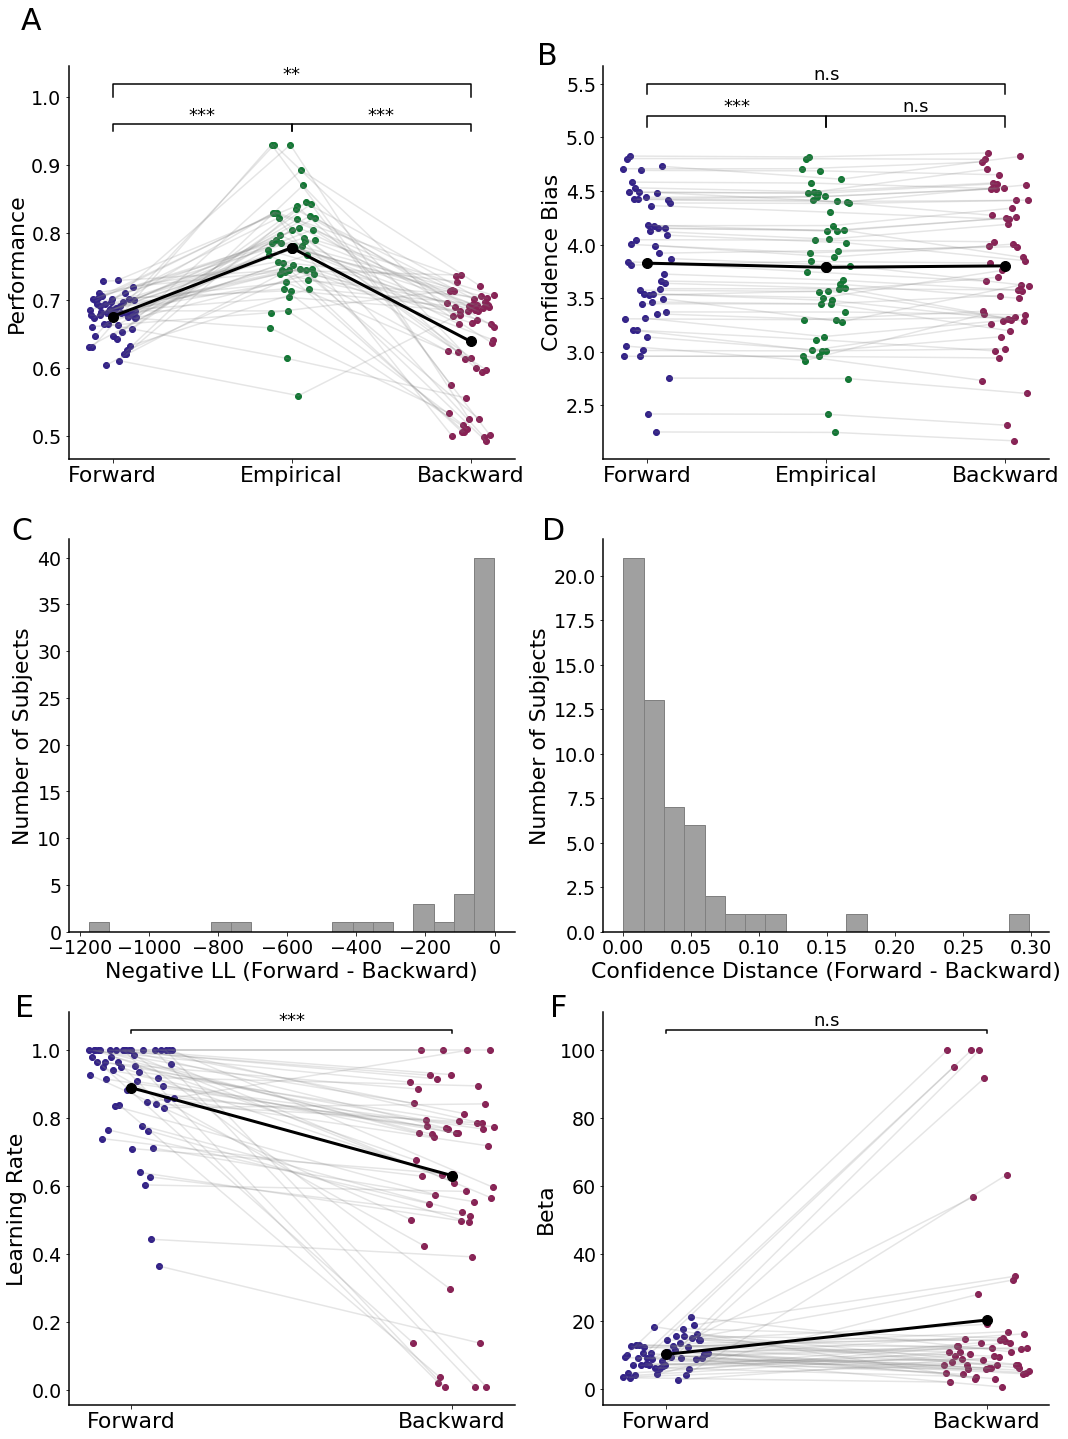

In [80]:
plt.figure(figsize=(15, 20))

plt.subplot(3,2,1)


groups = ["Forward", "Empirical", "Backward"]


comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [0.95, 0.95, 1],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)

plt.text(-75, 1.1, "A", fontsize=30)


plt.subplot(3,2,2)

plt.text(-95, 5.68, "B", fontsize=30)

groups = ["Forward", "Empirical", "Backward"]

comparison_plot(
    avg_df,
    "mean conf",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [5.1, 5.1, 5.4],
    [0.1, 0.1, 0.1],
    legend="lower right",
    y_label="Confidence Bias",
)

plt.subplot(3,2,3)

plt.text(-1400, 42, "C", fontsize=30)

groups = ["Forward", "Backward"]

plot_histogtram(forward_df["LL"] - backward_df["LL"],
                "grey",
                "Negative LL (Forward - Backward)"
)

plt.subplot(3,2,4)

plt.text(-.06, 22, "D", fontsize=30)

plot_histogtram(forward_df["Confidence Distance"] - backward_df["Confidence Distance"],
                "grey",
                "Confidence Distance (Forward - Backward)"
               )


plt.subplot(3,2,5)

plt.text(-45, 1.1, "E", fontsize=30)

comparison_plot(
    params_df,
    "alpha",
    groups,
    "",
    [["Forward", "Backward"]],
    [1.05, 1.05],
    [0.01, 0.01],
    y_label="Learning Rate",
)

plt.subplot(3,2,6)

plt.text(-45, 110, "F", fontsize=30)

comparison_plot(
    params_df,
    "beta",
    groups,
    "",
    [["Forward", "Backward"]],
    [105, 105],
    [1, 1],
    y_label="Beta",
)



plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("fig3main_high.png", dpi=400, bbox_inches = "tight")

## Figure 4

In [81]:
# Calculate QSR, empirical accuracy (emp_acc), and empirical confidence judgment (emp_cj) 
emp_metrics_df = lv_induction_data.groupby("sub").apply(lambda x: pd.Series({
    "QSR": group_qsr(x),
    "emp_acc": x["cor"].mean(),
    "emp_cj": x["cj"].mean()
})).reset_index().rename(columns={"sub": "subject"})

# Merge all necessary DataFrames together
backward_emp_df = averaged_dataframes[2].merge(emp_metrics_df, on="subject")\
                                .merge(scaled_brier_df[["subject", "scaled_QSR"]], on="subject")

# Correctly align 'forward_cor' with subjects in 'backward_emp_df'
# This assumes 'forward_avg_df' is indexed by 'subject'; if not, ensure it is or adjust as necessary
forward_cor_aligned = backward_emp_df["subject"].map(averaged_dataframes[0].set_index("subject")["cor"])

# do the same for the backward_unscaled
backward_usncaled_cor_aligned = backward_emp_df["subject"].map(averaged_dataframes[3].set_index("subject")["cor"])


# Add new columns for MetaRL calculations and confidence bias
backward_emp_df["forward_cor"] = forward_cor_aligned
backward_emp_df["backward_unscaled_cor"] = backward_usncaled_cor_aligned
backward_emp_df["MetaRL"] = backward_emp_df["cor"] / backward_emp_df["forward_cor"]
backward_emp_df["MetaRL_unscaled"] = backward_emp_df["backward_unscaled_cor"] / backward_emp_df["forward_cor"]

# Rename columns as needed
backward_emp_df = backward_emp_df.rename(columns={"cor": "backward_cor"})

# Ensure the DataFrame is correctly formatted
backward_emp_df = backward_emp_df[['subject', 'backward_cor', 'QSR', 'emp_acc', 'emp_cj', 'scaled_QSR', 'forward_cor', 'MetaRL', 'MetaRL_unscaled']]

backward_with_params = pd.merge(backward_emp_df, forward_df, on =["subject"])

(p = 2.03e-01, r = 0.18,ci = [-0.10,0.42])
(p = 8.53e-01, r = 0.03,ci = [-0.24,0.29])


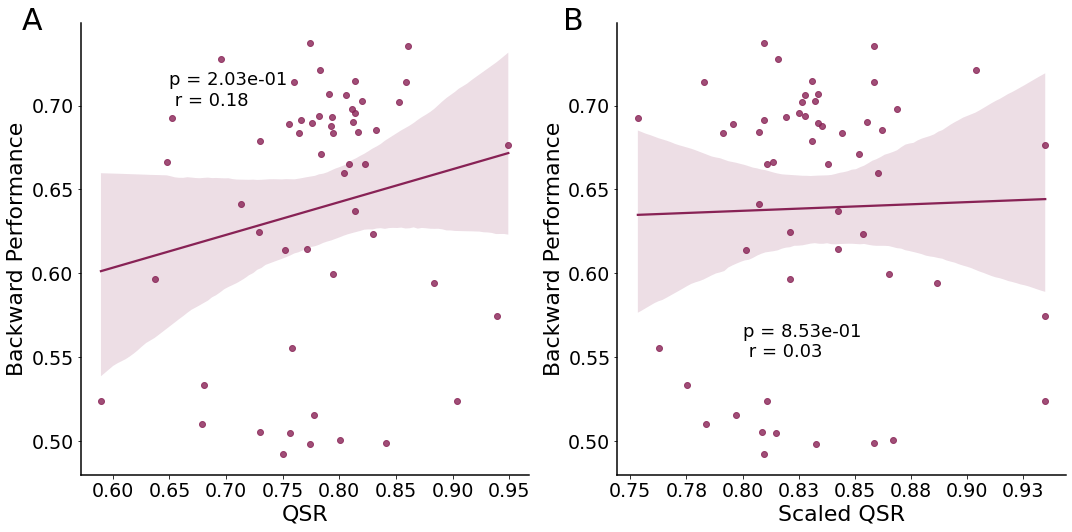

In [82]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(15, 7.5))

plt.subplot(1,2,1)

plot_regression_df(backward_emp_df, "QSR", "backward_cor", color_dict["Backward"] ,0.65, 0.7, "QSR", "Backward Performance")

plt.text(.52, .745, "A", fontsize=30)

plt.subplot(1,2,2)

plt.text(.72, .745, "B", fontsize=30)


plot_regression_df(backward_emp_df, "scaled_QSR", "backward_cor", color_dict["Backward"] ,0.8, 0.55, "Scaled QSR", "Backward Performance")

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("fig4main_high.png", dpi=400, bbox_inches = "tight")


## Figure 5

(p = 8.20e-01, r = 0.03,ci = [-0.24,0.30])
(p = 3.53e-01, r = 0.13, ci = [-0.14,0.38])
(p = 5.68e-01, r = -0.08,ci = [-0.34,0.19])
(p = 4.53e-01, r = 0.10,ci = [-0.17,0.36])


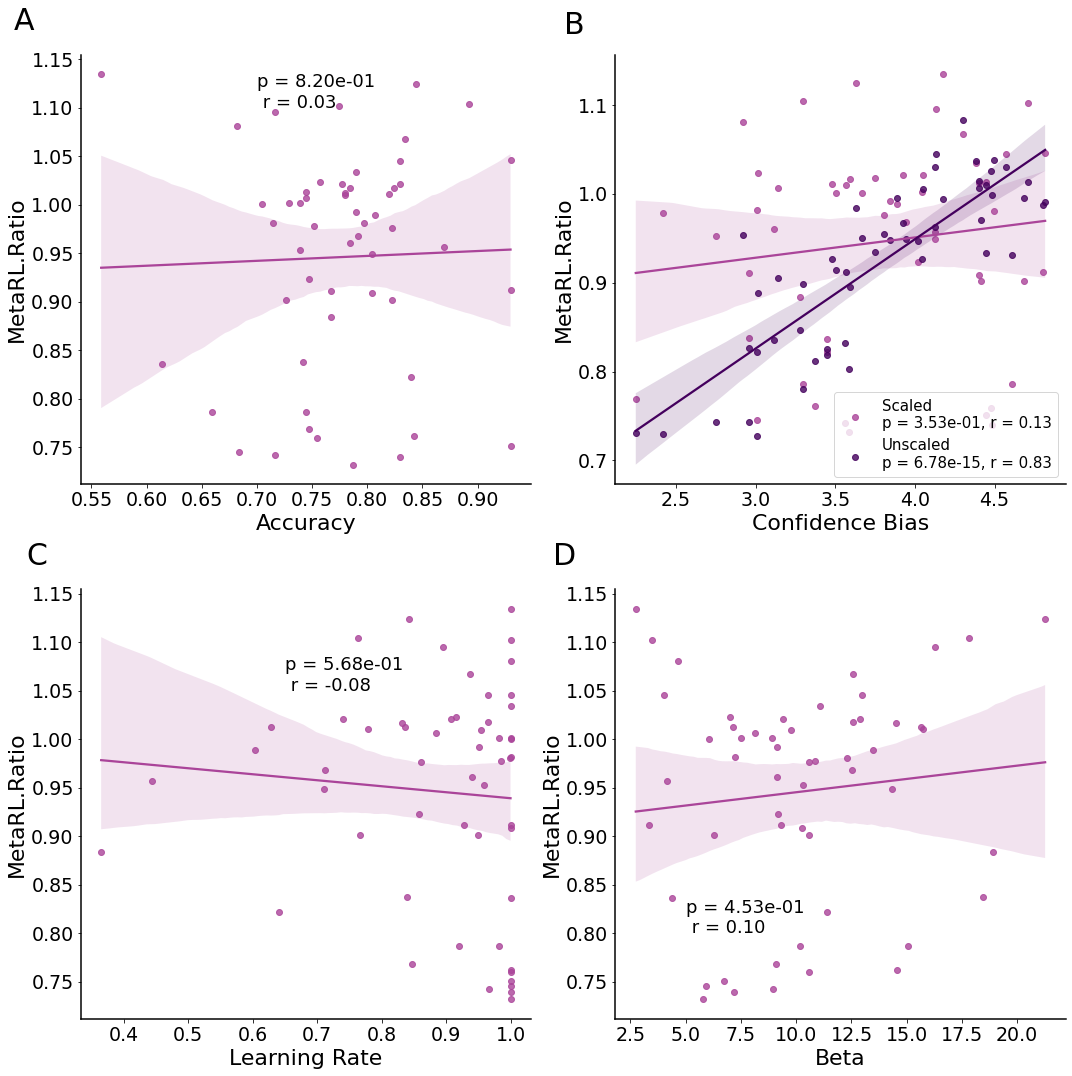

In [109]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)

plt.text(.48, 1.18, "A", fontsize=30)

plot_regression_df(backward_emp_df, "emp_acc", "MetaRL", "#AA4499",0.7, 1.1, "Accuracy", "MetaRL.Ratio")


plt.subplot(2,2,2)

plt.text(1.8, 1.18, "B", fontsize=30)

res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

res2 = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

stat2, pval2= res2 
r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL", color="#AA4499", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="#44005D", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.legend(fontsize=15, loc = "lower right")


plt.subplot(2,2,3)

plt.text(.25, 1.18, "C", fontsize=30)

plot_regression_df(backward_with_params, "alpha", "MetaRL", "#AA4499",0.65, 1.05, "Learning Rate", "MetaRL.Ratio")

plt.subplot(2,2,4)

plt.text(-1, 1.18, "D", fontsize=30)

plot_regression_df(backward_with_params, "beta", "MetaRL", "#AA4499", 5, .8, "Beta", "MetaRL.Ratio")


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("fig5main_high.png", dpi=400, bbox_inches = "tight")



## Supp figure 5

(p = 1.13e-11, r = 0.77,ci = [0.63,0.86])
(p = 6.11e-02, r = 0.26,ci = [-0.01,0.49])


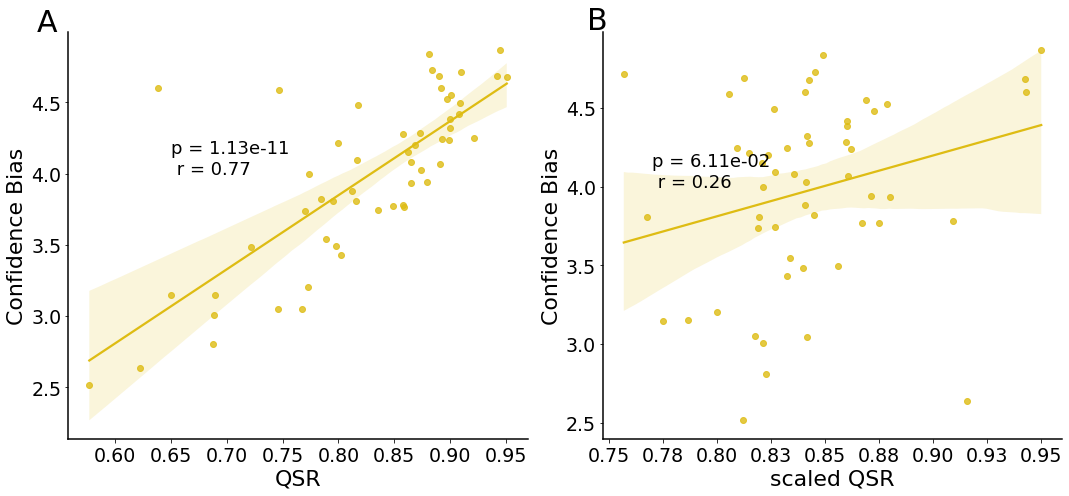

In [11]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)

plt.text(.53, 5, "A", fontsize=30)

plot_regression_df(backward_emp_df, "QSR", "emp_cj", "#DEBC13",0.65, 4, "QSR", "Confidence Bias")


plt.subplot(1,2,2)
plt.text(.74, 5, "B", fontsize=30)

plot_regression_df(backward_emp_df, "scaled_QSR", "emp_cj", "#DEBC13",0.77, 4, "scaled QSR", "Confidence Bias")

ax = plt.gca()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/supp_fig5_high.png", dpi=400, bbox_inches='tight')


In [12]:
r1 = 0.77
r2 = .31
n1 = len(subjects)
n2 = len(subjects)
z, p_value = compare_correlations(r1,r2,n1,n2)
print(r"z = {:.2f}".format(z), "p_val = {:.2e}".format(p_value))

z = 3.53 p_val = 4.10e-04


## Supp figure 6

Statistics for Forward and Backward =256.0, p=1.117e-03
mean Forward = 2.28
mean Backward = 2.06
Statistics for Forward and Backward =298.0, p=2.190e-04
mean Forward = 4.15
mean Backward = 4.42


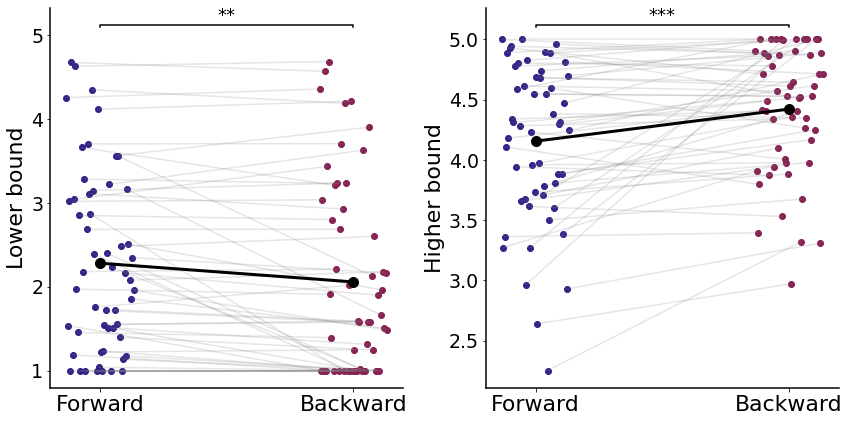

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
comparison_plot(
    params_df,
    "lbound",
    groups,
    "",
    [["Forward", "Backward"]],
    [5.1],
    [0.02],
    y_label="Lower bound",
)
plt.subplot(1, 2, 2)
comparison_plot(
    params_df,
    "hbound",
    groups,
    "",
    [["Forward", "Backward"]],
    [5.1],
    [0.02],
    y_label="Higher bound",
)
plt.tight_layout()

plt.savefig("../figs/supp_fig6_high.png", dpi=400, bbox_inches = "tight")


In [14]:
forward_simulation_high_df = pd.read_csv("../results/forward_simulation_df_high.csv")
forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")


In [15]:
forward_simulation_high_df = calculate_averages(forward_simulation_high_df)
forward_simulation_df = calculate_averages(forward_simulation_df)

In [3]:
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "hc")
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")
backward_simulation_df = pd.read_csv("../results/backward_simulation_df.csv")
backward_unscaled_simulation_df = pd.read_csv("../results/backward_simulation_unscaled_df.csv")

hv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "lc1")
human_hv_df = hv_induction_data.rename(columns={"sub": "subject"})

forward_simulation_df_high = pd.read_csv("../results/forward_simulation_df_high.csv")
backward_simulation_df_high = pd.read_csv("../results/backward_simulation_df_high.csv")
backward_unscaled_simulation_df_high = pd.read_csv("../results/backward_simulation_unscaled_df_high.csv")


In [4]:
def calculate_averages(df):
    """
    Group by 'subject' and calculate the mean of 'reward', 'cor', and 'cj'. 
    """
    return df.groupby("subject").agg({"reward": "mean", "cor": "mean", "cj": "mean"}).reset_index()

dataframes = [forward_simulation_df, human_lv_df, backward_simulation_df, backward_unscaled_simulation_df]
averaged_dataframes = [calculate_averages(df) for df in dataframes]

groups = ["Forward", "Empirical", "Backward", "Backward_unscaled"]

avg_df = merge_result_df(averaged_dataframes, groups, 200, subjects)

# Rename columns in the merged DataFrame
avg_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace=True)


In [5]:
dataframes_high = [forward_simulation_df_high, human_hv_df, backward_simulation_df_high, backward_unscaled_simulation_df_high]
averaged_dataframes_high = [calculate_averages(df) for df in dataframes_high]

groups = ["Forward", "Empirical", "Backward", "Backward_unscaled"]

avg_df_high = merge_result_df(averaged_dataframes_high, groups, 200, subjects)

# Rename columns in the merged DataFrame
avg_df_high.rename(columns={"reward": "mean_reward_high", "cor": "accuracy_high", "cj": "mean conf_high"}, inplace=True)


In [6]:
# Merge on two columns: 'key1' and 'key2'
merged_df = pd.merge(avg_df, avg_df_high, on=['subject', 'model'], how='inner')


In [19]:
back_df = avg_df[avg_df["model"] == "Backward"].rename(columns={"accuracy":"back_acc"})
forward_df = avg_df[avg_df["model"] == "Forward"].rename(columns={"accuracy":"for_acc"})
meta_rl = pd.merge(back_df,forward_df, on =["subject"], how="inner")
meta_rl["meta_rl"] = meta_rl["back_acc"]/ meta_rl["for_acc"]
meta_rl

back_df_high = avg_df_high[avg_df_high["model"] == "Backward"].rename(columns={"accuracy_high":"back_acc"})
forward_df_high = avg_df_high[avg_df_high["model"] == "Forward"].rename(columns={"accuracy_high":"for_acc"})
meta_rl_high = pd.merge(back_df_high,forward_df_high, on =["subject"], how="inner")
meta_rl["meta_rl_high"] = meta_rl_high["back_acc"]/ meta_rl_high["for_acc"]


In [20]:
meta_rl

,subject,mean_reward_x,back_acc,mean conf_x,model_x,x_idx_x,mean_reward_y,for_acc,mean conf_y,model_y,x_idx_y,meta_rl,meta_rl_high
0,45628,0.557762,0.788875,4.681759,Backward,401,0.556503,0.783400,4.680113,Forward,1,1.006989,1.085417
1,45640,0.500956,0.502150,4.503421,Backward,402,0.560373,0.799925,4.496104,Forward,2,0.627746,0.905348
2,45664,0.500535,0.500425,3.142637,Backward,403,0.554853,0.760300,3.148277,Forward,3,0.658194,0.763219
3,45682,0.533940,0.652875,4.015574,Backward,404,0.552668,0.756550,3.734820,Forward,4,0.862963,1.067360
4,45745,0.547686,0.737750,4.730667,Backward,405,0.552083,0.759250,4.754387,Forward,5,0.971683,0.909815
5,45760,0.552388,0.759400,4.414322,Backward,406,0.552267,0.757950,4.386625,Forward,6,1.001913,1.010815
6,45763,0.556043,0.779975,4.354799,Backward,407,0.553990,0.770825,4.460488,Forward,7,1.011870,0.743841
7,45805,0.536985,0.684925,4.866092,Backward,408,0.546670,0.733850,4.880318,Forward,8,0.933331,1.065812
8,45829,0.558499,0.776250,3.984504,Backward,409,0.559408,0.781850,3.954754,Forward,9,0.992838,0.997842
9,45964,0.554797,0.767750,4.025019,Backward,410,0.554917,0.771150,3.845515,Forward,10,0.995591,1.008729


(p = 6.21e-01, r = 0.07,ci = [-0.20,0.33])
(p = 4.98e-01, r = -0.09,ci = [-0.35,0.18])
(p = 1.37e-02, r = 0.33,ci = [0.07,0.55])
(p = 1.42e-01, r = 0.20,ci = [-0.07,0.45])


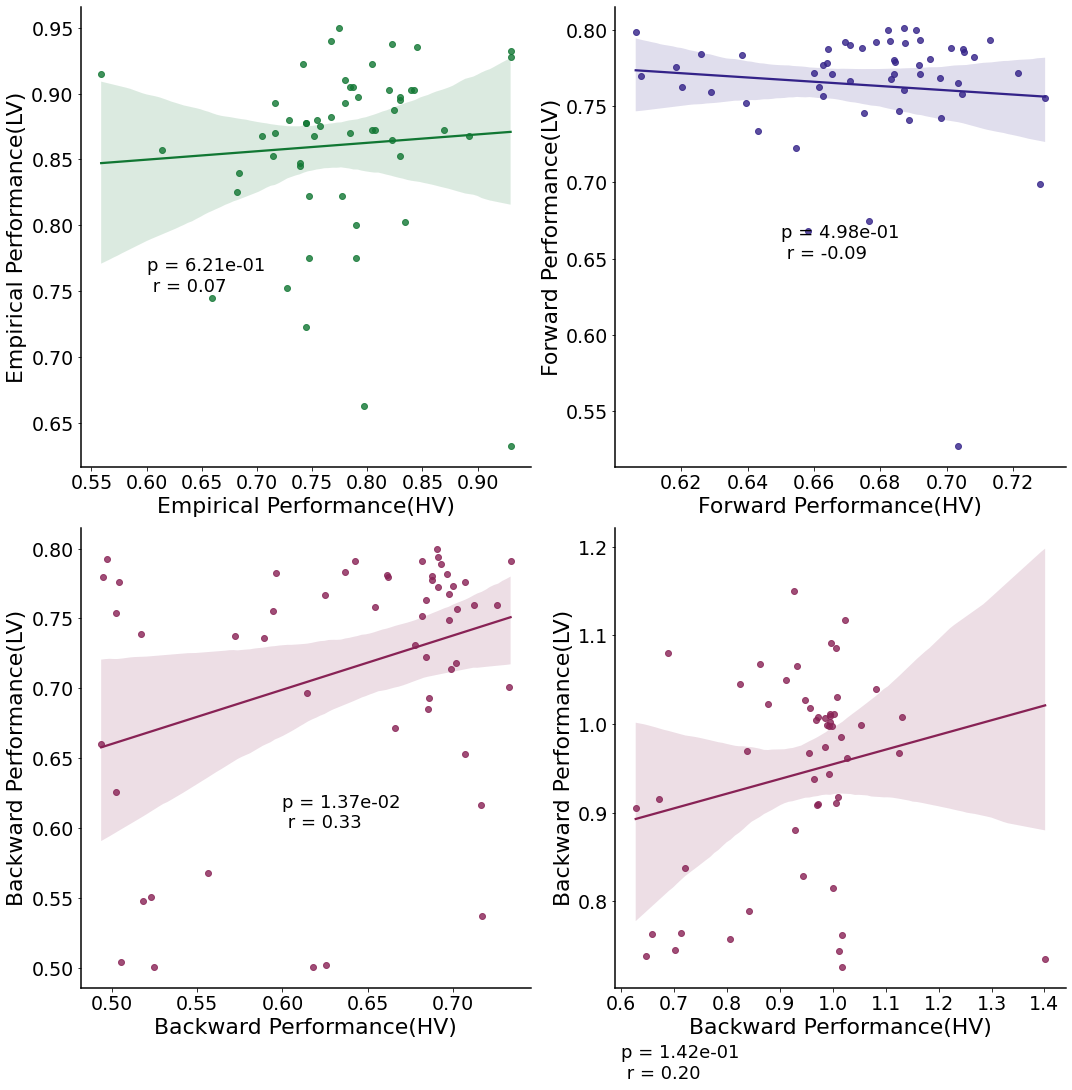

In [21]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plot_regression_df(merged_df[merged_df["model"]=="Empirical"], "accuracy_high", "accuracy", "#117733",0.6, .75, "Empirical Performance(HV)", "Empirical Performance(LV)")

plt.subplot(2,2,2)
plot_regression_df(merged_df[merged_df["model"]=="Forward"], "accuracy_high", "accuracy", "#332288",0.65, .65, "Forward Performance(HV)", "Forward Performance(LV)")

plt.subplot(2,2,3)
plot_regression_df(merged_df[merged_df["model"]=="Backward"], "accuracy_high", "accuracy", "#882255",0.6, .6, "Backward Performance(HV)", "Backward Performance(LV)")

plt.subplot(2,2,4)
plot_regression_df(meta_rl, "meta_rl", "meta_rl_high", "#882255",0.6, .6, "Backward Performance(HV)", "Backward Performance(LV)")

plt.tight_layout()


(p = 4.86e-09, r = 0.70,ci = [0.53,0.81])
(p = 2.87e-09, r = 0.70,ci = [0.54,0.82])
(p = 7.97e-09, r = 0.69,ci = [0.52,0.81])


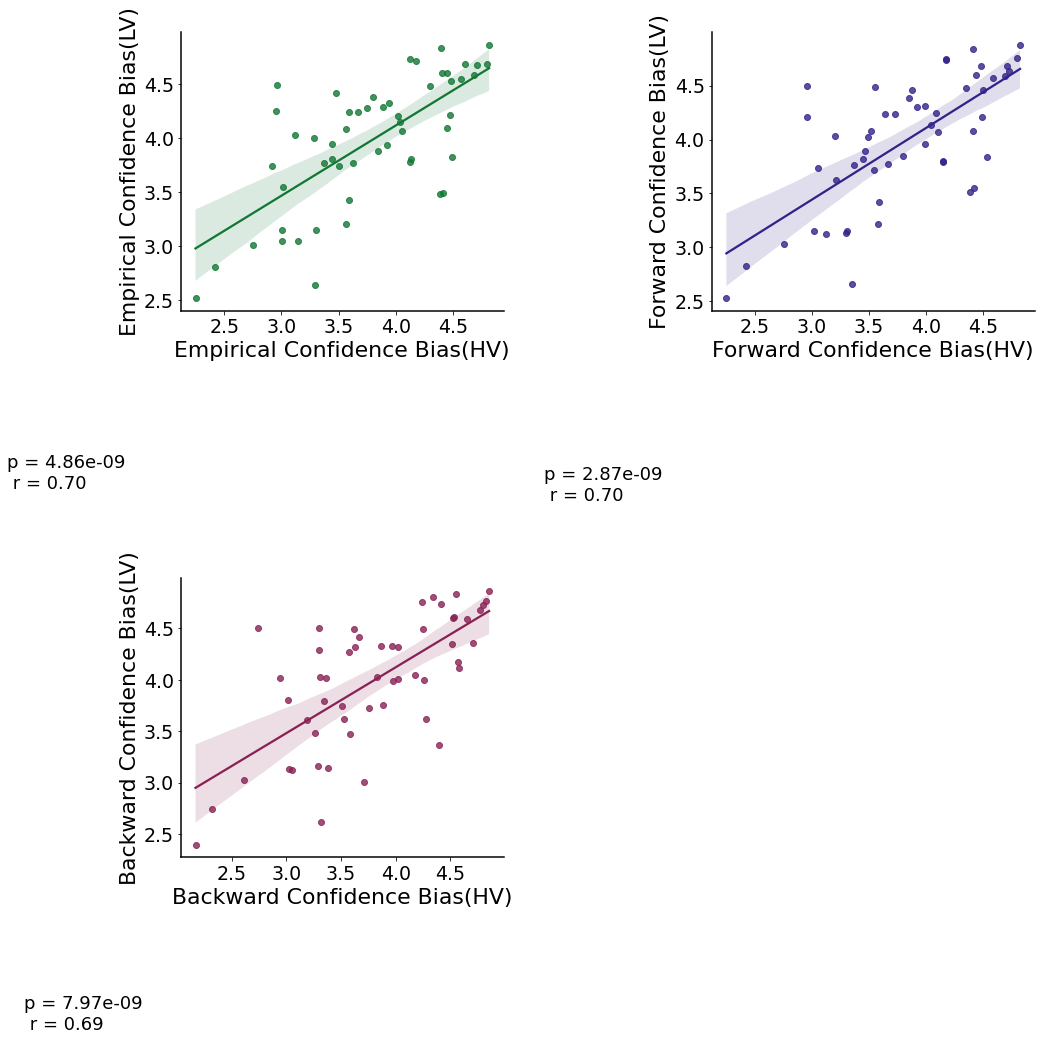

In [86]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plot_regression_df(merged_df[merged_df["model"]=="Empirical"], "mean conf_high", "mean conf", "#117733",0.6, .75, "Empirical Confidence Bias(HV)", "Empirical Confidence Bias(LV)")

plt.subplot(2,2,2)
plot_regression_df(merged_df[merged_df["model"]=="Forward"], "mean conf_high", "mean conf", "#332288",0.65, .65, "Forward Confidence Bias(HV)", "Forward Confidence Bias(LV)")

plt.subplot(2,2,3)
plot_regression_df(merged_df[merged_df["model"]=="Backward"], "mean conf_high", "mean conf", "#882255",0.6, .6, "Backward Confidence Bias(HV)", "Backward Confidence Bias(LV)")

plt.tight_layout()


In [79]:
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", "lc1")
subjects = lv_induction_data["sub"].unique()

forward_df = pd.read_csv("../results/forward_df_high.csv")
backward_df = pd.read_csv("../results/backward_df_high.csv")
backward_df_unscaled = pd.read_csv("../results/backward_df_unscaled_high.csv")
scaled_brier_df = pd.read_csv("../results/scaled_brier_df_high.csv")
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})


seed = 21
seed = 0

# Set the random seed
np.random.seed(seed)
random.seed(seed)

forward_simulation_df = simulate_with_params(forward_df, lv_induction_data, subjects, n= 100)
backward_simulation_df = simulate_with_params(backward_df, lv_induction_data, subjects, n= 100)
backward_unscaled_simulation_df = simulate_with_params(backward_df_unscaled, lv_induction_data, subjects, n= 100)

forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_unscaled_simulation_df.rename(columns={"sub": "subject"}, inplace=True)



KeyboardInterrupt: 